# FIFA 19 Analytics
Predict FIFA 19 players' values and overall score using their respective physical ability values, and applicaiton of machine and deep learning.

Dataset acquired from https://www.kaggle.com/karangadiya/fifa19.

## Data exploration
The simplest way of knowing what kind of data we are dealing with is to actually see the data itself.

### Package importation
Change the path to the path where 'data.csv' is stored.

In [2]:
import pandas as pd
import numpy as np
import sklearn
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount(r'/content/gdrive')
path = r'gdrive/My Drive/Colab Notebooks/fifa/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data cleaning and preparation
1. Remove irrelevant fields
2. Remove Goalkeepers (GK) as they have different categories of physical values and other implications.
3. Logarithmic values of 'Value' (Market value of players) for better regression (This is done on hindsight after the data visualisation step).
4. Categorise relevant fields ('Position' and 'Club') to numerical values (Optional).
5. Remove additional index fields being added by reset_index().

In [3]:
df = pd.read_csv(path+'data.csv', index_col = 0)
drop_cols = ['ID','Photo','Flag','Club Logo','Release Clause']
for col in drop_cols:
  df.drop(col, axis=1, inplace=True)

df = df[df['Position'] != 'GK']
df = df[df.Value != '']
df.reset_index(inplace=True)

dec_mul = df.Value.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int)
df.Value = dec_mul * df.Value.replace(['K','M','€'], '', regex=True).astype(float)
df = df[df.Value != 0]
df['Value_log'] = np.log(df.Value)

df.Position = df.Position.astype('category')
df.Position = df.Position.dropna()
df['Position_codes'] = df.Position.cat.codes
df.reset_index(inplace=True)

df.Club = df.Club.astype('category')
df['Club_codes'] = df.Club.cat.codes

df.drop('level_0', axis = 1, inplace = True)
df.drop('index', axis = 1, inplace = True)

pos_codes = dict(enumerate(df.Position.cat.categories))
club_codes = dict(enumerate(df.Club.cat.categories))
print(pos_codes)

{0: 'CAM', 1: 'CB', 2: 'CDM', 3: 'CF', 4: 'CM', 5: 'LAM', 6: 'LB', 7: 'LCB', 8: 'LCM', 9: 'LDM', 10: 'LF', 11: 'LM', 12: 'LS', 13: 'LW', 14: 'LWB', 15: 'RAM', 16: 'RB', 17: 'RCB', 18: 'RCM', 19: 'RDM', 20: 'RF', 21: 'RM', 22: 'RS', 23: 'RW', 24: 'RWB', 25: 'ST'}


### Data visualisation
'Value' (Market value of the player) against 'Overall' (Overall score of the player). It is observed that they are related exponentiallly. Logarithmic value of 'Value' ('Value_log') against 'Overall' shows a more linear relationship.

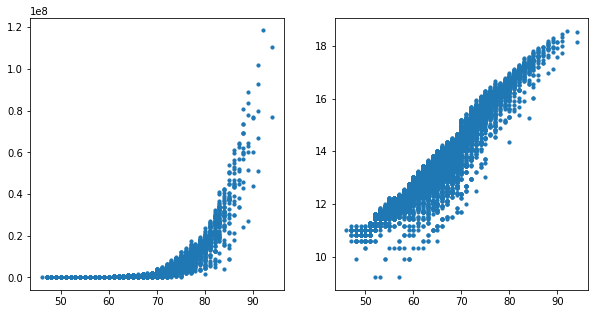

In [4]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))
ax[0].scatter(df['Overall'], df['Value'], s=10)
ax[1].scatter(df['Overall'], df['Value_log'], s=10)

## Linear regression
As the graph appeared to be almost linear, linear regression model will be used to represent their relationship.

### Model and data preparation
Scikit-learn package is used in this step. The data ('Overall' and 'Value_log') is split into 'train' (to train the model) and 'test' (to test the accuracy of the model). It is important to shuffle the data as most of the data come with some sort of ordering, which will bias the model.

In [0]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

regr = linear_model.LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(df['Overall'].values ,df['Value_log'].values, shuffle = True)

X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

### Model training
Training set is used to train the linear regression model. The red line represents the regressed linear relationship.

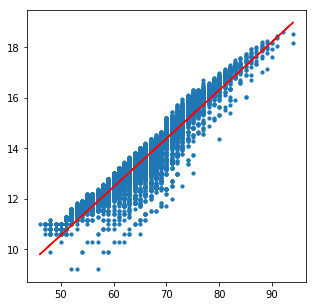

In [6]:
regr.fit(X_train, y_train)
plt.figure(figsize=(5,5))
plt.scatter(X_train, y_train, s=10)
plt.plot(X_train, regr.coef_[0]*X_train + regr.intercept_, '-r')

### Model validation
Mean squared error is to represent how far each predicted data point ('y_hat') distanced from the actual ('y_test'), the lower the more accurate it is.   
R2 score is used to show how fit is the model by comparing predicted and actual values, with the values range from 0 to 1, with 1 being the fittest.

In [7]:
y_hat = regr.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_hat))
print("R2-score: %.2f" % r2_score(y_test, y_hat))

Mean squared error: 0.19
R2-score: 0.90


## Deep learning
Neural network model comprises of layers of neurons connecting together. There are input layer, capable of taking multiple inputs; hidden (middle) layers, and; and output layer. The hidden layer(s) are responsible of carrying out arithmetic operations, which is randomly initialised and will be trained by our data.

In this step, the aim is to predict the overall scores 'Overall' from each physical charateristic values of the players.

As these values were set by the game FIFA 19, they are not the actual representation of the capabilities of the players.

### Package importation
Keras package will be used in this step.

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


### Data cleaning and preparation
1. Removing players that have incomplete values.
2. Train-test split. We will define our own splitting function by using numpy mask function. However, the split is not exact as they are randomised.

Realistically, the players' playing position will influence the weights of each values possess, but for this example it will be ignored.

In [9]:
data = df.copy()

nan_stats = np.argwhere(data.loc[:,'Crossing':'SlidingTackle'].isnull().any(axis = 1)).reshape(-1)
for i in nan_stats:
  data.drop(i, axis = 0, inplace=True)

data = data.sample(frac=1)

X = data.loc[:,'Crossing':'SlidingTackle'].values
y = data.loc[:,'Overall'].values

def tt_split(X,y,ratio):
  mask = (np.random.rand(X.shape[0]) >= ratio)
  return X[mask], X[~mask], y[mask], y[~mask]

X_train, X_test, y_train, y_test = tt_split(X, y, 0.2)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


### Model creation
There is not an exact rule in creating a neural network model. However, the more complicated it is, the slower it is trained and predicts.

**Input layer:** Same number of nodes as the number of data fields.  
**Hidden layers:** 2 dense layers with 128 nodes, meaning each node from each layer will be connect to all nodes on the next layer. Activation layers are included between each dense layers to simulate "all-or-nothing" mechanism similar to a biological neuron.  
**Output layer:** A single neuron receiving all connection from previous dense layer. This is where the predicted value is.

**Loss** will be calculated in each epoch (A full cycle of training by exhausting all training data) to represent how well the model is performing at that stage.  
**Optimizer** is responsible of tweaking the model to improve the model at the next training cycle.


In [10]:
nodes = 128
model = Sequential()
model.add(Dense(nodes, input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(Dense(nodes))
model.add(Activation('relu'))
model.add(Dense(nodes))
model.add(Activation('relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer='Adam',
              metrics=['accuracy'])

W0826 05:39:43.928645 140465089685376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 05:39:43.943898 140465089685376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 05:39:43.947461 140465089685376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 05:39:44.107772 140465089685376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Fitting in
The model will be trained for 200 epochs. At each epochs, only 70% of training data will be used to train the model, and the remaining 30% is used to validate the accuracy of the model at that point.  
Note that the original 'test' data is still untouched and not yet seen by the model.

In [0]:
model.fit(X_train, y_train, epochs=200, validation_split=0.3)

### Model validation
The predicted values from 'X_test' ('y_hat') are visualised against the actual value ('y_test'). They are shown to have similar distributions on all axes.

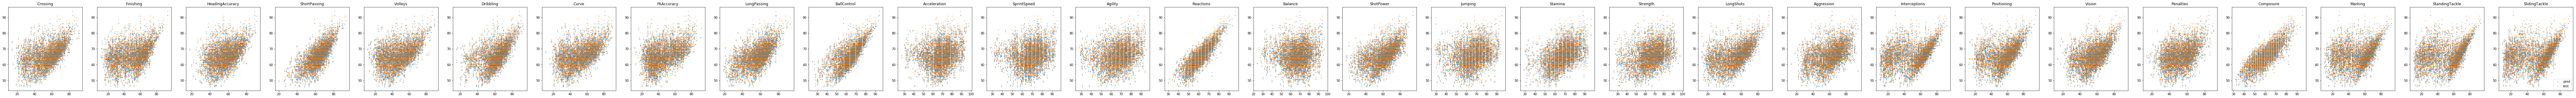

In [12]:
y_hat = model.predict(X_test)
_, axes = plt.subplots(1, X.shape[-1], figsize = (150,5))
for c in range(axes.shape[0]):
    axes[c].scatter(X_test[:,c], y_hat[:], s=4, label='pred', alpha=0.5)
    axes[c].scatter(X_test[:,c], y_test[:], s=4, label='test', alpha=0.5)
    axes[c].set_title(data.loc[:,'Crossing':'SlidingTackle'].columns[c])
plt.legend()

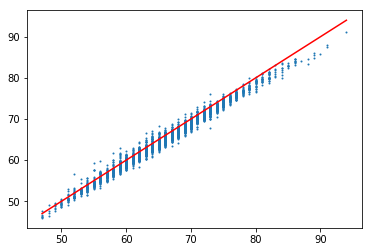

In [15]:
# horizontal-axis: test actual y, vertical-axis: predicted y
plt.scatter(y_test[:], y_hat[:], s=1)
# reference line, where an ideal model prediction is completely accurate
plt.plot([y_test[:].min(), y_test[:].max()], [y_test[:].min(), y_test[:].max()], 'r')

### Model application
Let's have a player called John Doe and see how well he will fare in FIFA 19 scoring system.

In [23]:
john_doe = np.array([51,78,78,50,70,61,96,58,80,79,67,50,68,70,
               88,86,67,40,55,58,64,47,90,61,72,67,80,71,77])
print(f'John Doe is predicted to have an overall score of {model.predict(np.array([john_doe]))[0][0]} in FIFA 19.')

John Doe is predicted to have an overall score of 67.66719818115234 in FIFA 19.
